# Data exploratory analysis

### In this short kernel we will review the data. We will, first, explore .csv file and than visualize images and masks

## 1. General content overview

The dataset consist of 3 csvs and 2 image sets: 
* The `train_v2/` and the `test_v2/` set of images, with 192 556 and 15 606 images each
* The `sample_submission_v2.csv` is a submit example, with the format of a solution. It has exactly 15 606 images to process.
* The `train_ship_segmentations_v2.csv` contains the run-length encoded bounding boxes for the ships in the `train_v2/` directory.
   - This `df` has two columns: `ImageId` and `EncodedPixels`
   - An image with more than one ship will have n rows in this csv, one for each ship. In other words each shim has separate row with mask in df.

In [70]:
import os


import pandas as pd
import matplotlib.pyplot as plt

from skimage.util import montage
from skimage.segmentation import mark_boundaries
from src.data_module import SegmentationDataModule
from src.utils import montage_rgb

Using TensorFlow backend.


In [2]:
%ls dataset

sample_submission_v2.csv  test_v2/  train_ship_segmentations_v2.csv  train_v2/


In [ ]:
train_csv_path = "dataset/train_ship_segmentations_v2.csv"
submission_csv_path = "dataset/train_ship_segmentations_v2.csv"

In [4]:
print(f"Images in train/: {len(os.listdir('../input/train_v2/'))}")
print(f"Images in test/ :  {len(os.listdir('../input/test_v2/'))}")

submit_images = pd.read_csv(train_csv_path)
print(f"Images for submission: {submit_images.shape[0]}")

submit_images.head()

Images in train/: 192556
Images in test/ :  15606

Images for submission: 15606


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## 2. A first glance at the csvs: ship vs. no-ship and total ships distribution

We will define two simple functions `load_df()` and `show_df()`. The first one loads a csv to pandas and creates the fields `HasShip` and `TotalShips` from `EncodedPixels`.  The second one displays the amount of images with and without ships and the distribution of total ships per image.

If you don't understand the `EncodedPixels`, you can refer to the [previous kernel](https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes) of this series, where we explain the `run-length encoding` in detail. 

As you can see, only the 22% of the images have at least one ship present, and more than 60% of those have only one ship.

In [67]:
def load_df(csv_path: str):
    """
    Loads a csv, creates the fields `HasShip` and `TotalShips` dropping `EncodedPixels` and setting `ImageId` as index.
    """
    df = pd.read_csv(csv_path)
    df['HasShip'] = df["EncodedPixels"].notnull()
    df = df.groupby("ImageId").agg({"HasShip": ["first", "sum"]}) # counts amount of ships per image, sets ImageId to index
    df.columns = ["HasShip", "TotalShips"]
    return df

def show_df(df: pd.DataFrame):
    """
    Prints and displays the ship/no-ship ratio and the ship count distribution of df
    """
    total = len(df)
    ship = df["HasShip"].sum()
    no_ship = total - ship
    total_ships = int(df["TotalShips"].sum())
    
    print(f"Images: {df.index.nunique()}")
    print(f"Images with ships:    {round(ship/total,2)} ({ship})")
    print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 10), gridspec_kw = {'width_ratios':[1, 3]})
    
    # Plot ship/no-ship with a bar plot
    ship_ratio = df["HasShip"].value_counts() / total
    ship_ratio = ship_ratio.rename(index={True: "Ship", False: "No Ship"})
    ship_ratio.plot.bar(ax=axes[0], color=["red", "green"], rot=0, title="Ship/No-ship distribution");
    
    # Plot TotalShips distribution with a bar plot
    total_ships_distribution = df.loc[df["HasShip"], "TotalShips"].value_counts().sort_index() / ship
    total_ships_distribution.plot(kind="bar", ax=axes[1], rot=0, title="Ships per image distribution");

Images: 192556
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


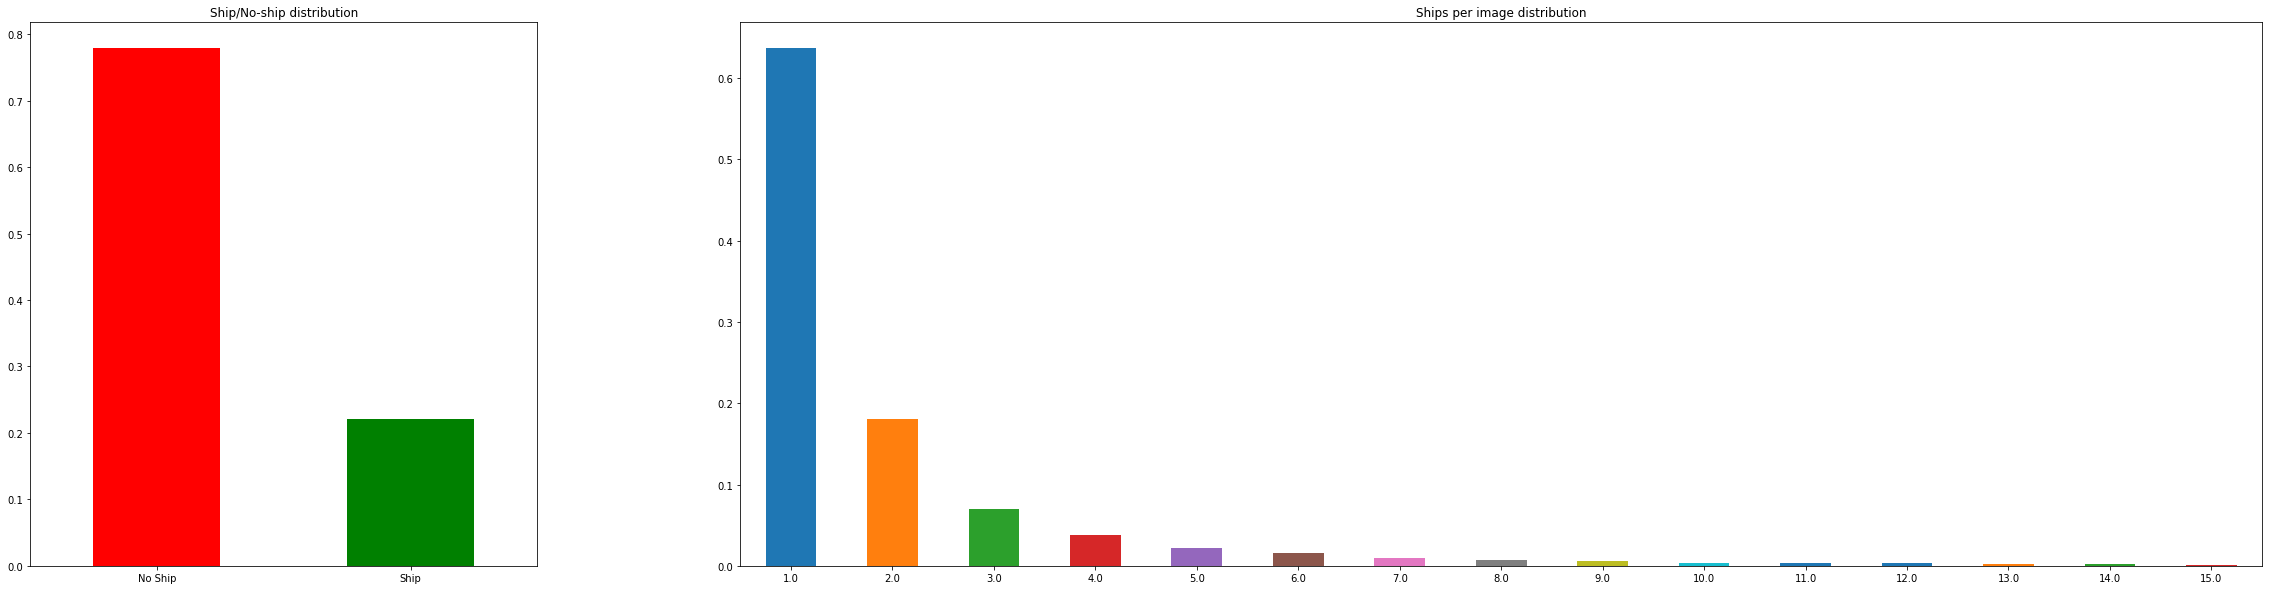

In [68]:
df_train = load_df(train_csv_path)
show_df(df_train)

The class imbalance of gets even worse when we don't consider the `images` but the `pixels`, as we will see in the next chapter.

## 3. Counting pixels: verifying the class imbalance between ship and no-ship pixels

The Challenge of detecting the ships in the images is semantic segmentation with two classes, can be thought as a `classification problem` for pixels, where, for each image, we need to classify 768 $\times$ 768 pixels in one of two classes: `ship` and `no-ship`. 

Below we will present the imbalance of the classes considering a `pixel-level` granularity, this is, we will check *how many pixels in the dataset corresponds to ships and how many to other stuff (no-ships)*

Few notes before diving into the code:
* The `total_pixels` is $ 768 \times 768 \times \text{n_imgs} $
* The total amount of `ship_pixels` is encoded in the `EncodedPixels`: it's actually the sum of the all the pair positions of those strings. 

In [28]:
def rle_to_pixels(rle_code: str):
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1:-2:2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def show_pixels_distribution(df: pd.DataFrame):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df["ImageId"].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df["EncodedPixels"].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")

In [31]:
df = pd.read_csv(train_csv_path)
show_pixels_distribution(df)

Ship: 0.001 (127777104)
No ship: 0.999 (113446373040)


In [33]:
show_pixels_distribution(df.dropna())

Ship: 0.005 (127777104)
No ship: 0.995 (24972773040)


As you can see above,  only 0.1‰ of the pixels are `ships`, while 99.9% of the pixels are `no-ships`. 

And, as you can see below, dropping all the images with no ships in them the class imbalance is reduced, but it's still very high: 5‰, this is, 0.5% of the pixels are `ships` while 99.5% are `no-ships`.

The conclusion is that dataset is highly imbalanced, so we'll need to handle it.

## 4. Distribution of ships size

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


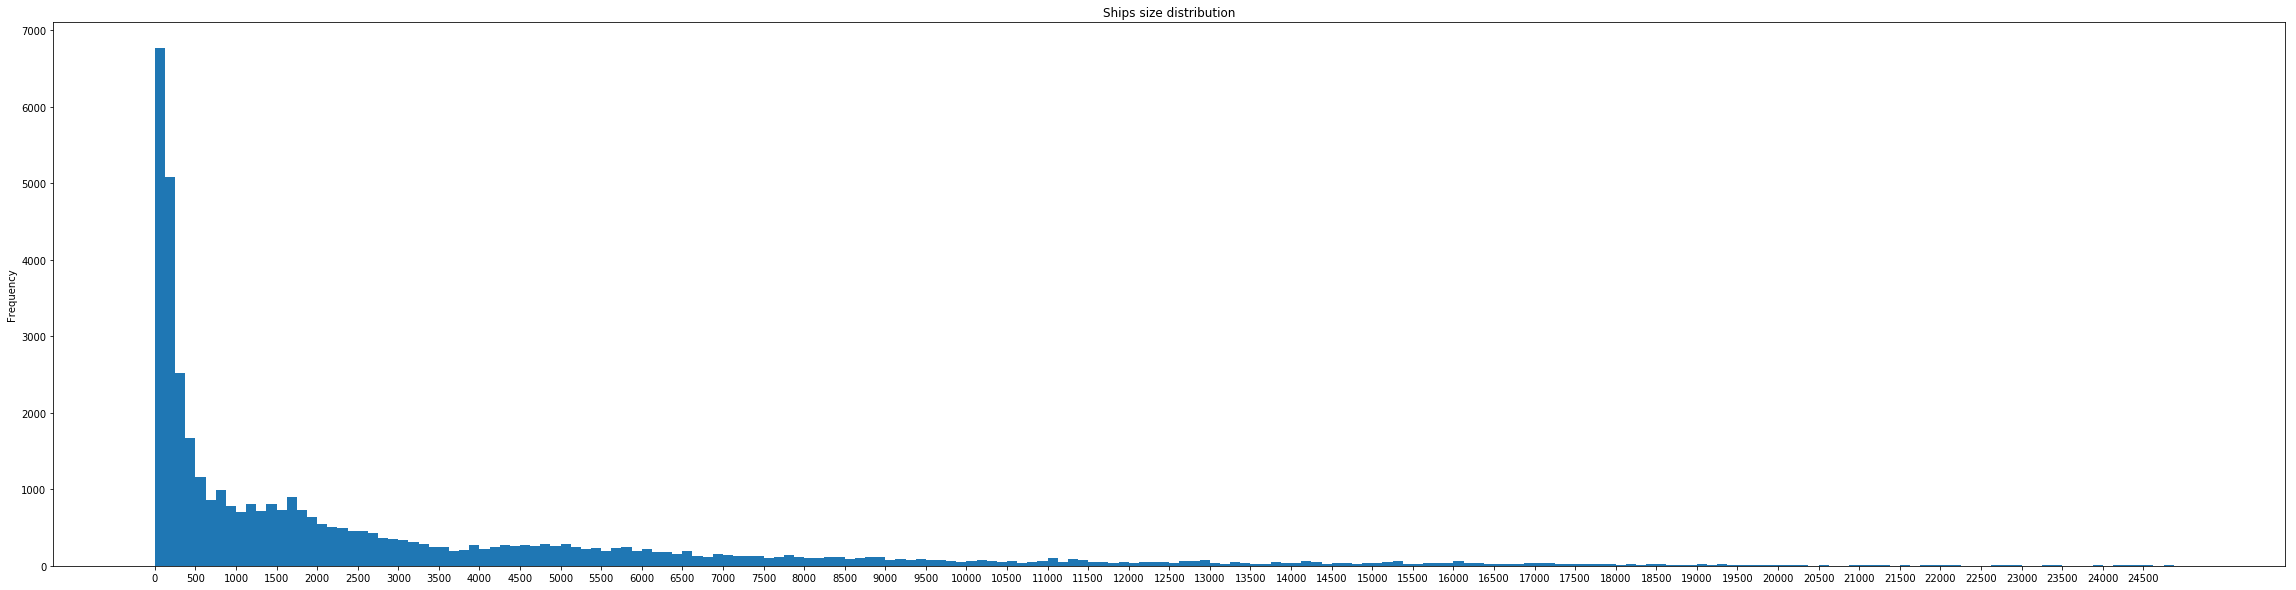

In [66]:
def calculate_ships_size(df: pd.DataFrame):
    df = df.dropna()
    
    # Calculate size of single ships
    df["ShipsSize"] = df["EncodedPixels"].apply(lambda mask: sum([int(width) for width in mask.split()[1::2]]))
    df = df.groupby("ImageId").sum()
    
    _, axes = plt.subplots(nrows=1, ncols=1, figsize=(40, 10))
    ships_size_distribution = df["ShipsSize"]
    ships_size_distribution.plot(kind="hist", bins=200, range=[0, 25000], title="Ships size distribution", xticks=[i for i in range(0, 25000, 500)])

df = pd.read_csv(train_csv_path)
calculate_ships_size(df)

#### As we can see big part of ships ~= 18000 are relatively small, their size is below 500 pixels (500/(768^2) = 0.000084% of area of the image). So we must be careful with downscaling images so that doesn't make these samples indistinguishable

## 5. Images visualisation

Text(0.5,1,'Outlined Ships')

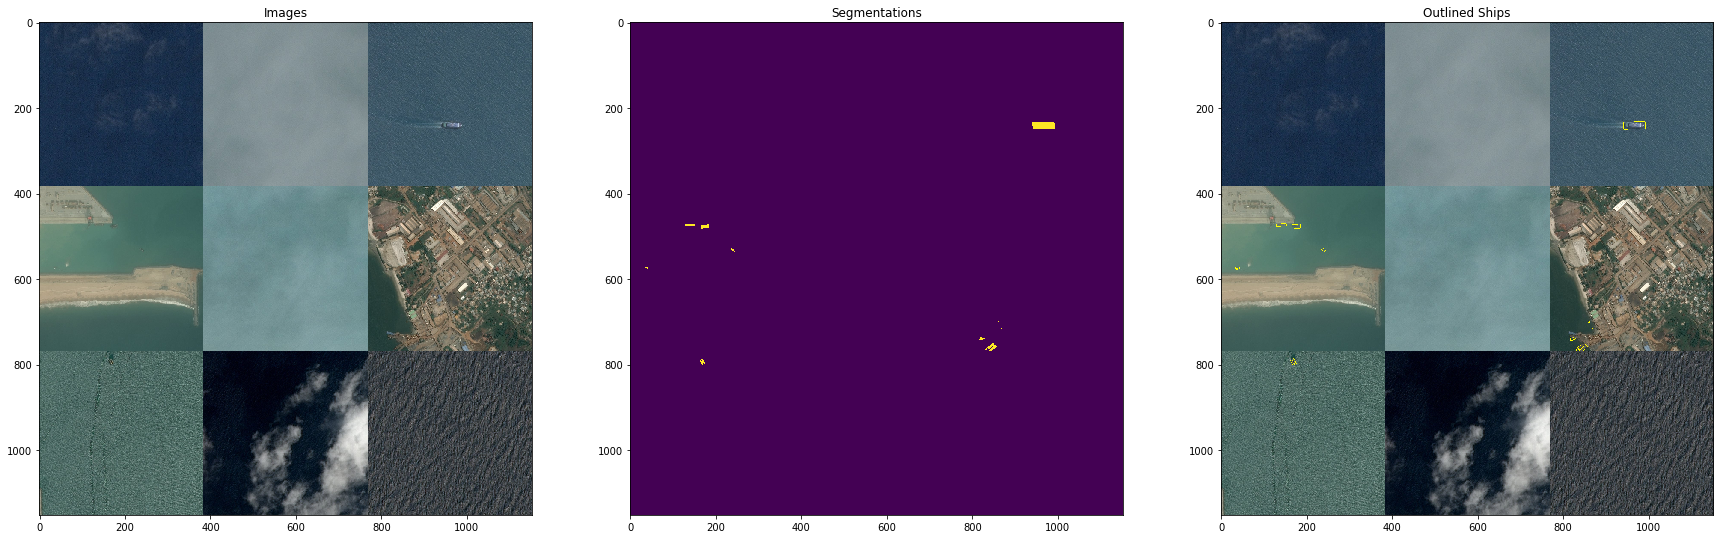

In [77]:
df = pd.read_csv(train_csv_path)
    
train_gen = iter(SegmentationDataModule(".dataset/train_v2/", df, 9, 384, False))
train_x, train_y = next(train_gen)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')

### As we can notice, the mask may not completely match the shape of the ship(ship's bow), which can be a challenging for the neural network to build an accurate boundary.